# Neural Network for Gaussian Probabilistic Model 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
%matplotlib inline

## Define a one dimensional function with varying gaussian noise: 
## $\ \ \ y = 2x + xsin(2x) + \epsilon$
## where
## $\ \ \ \epsilon\sim\mathcal{N}(0, \sigma)$
## and
## $\ \ \ \sigma\sim \mathscr{U}(0,x)$


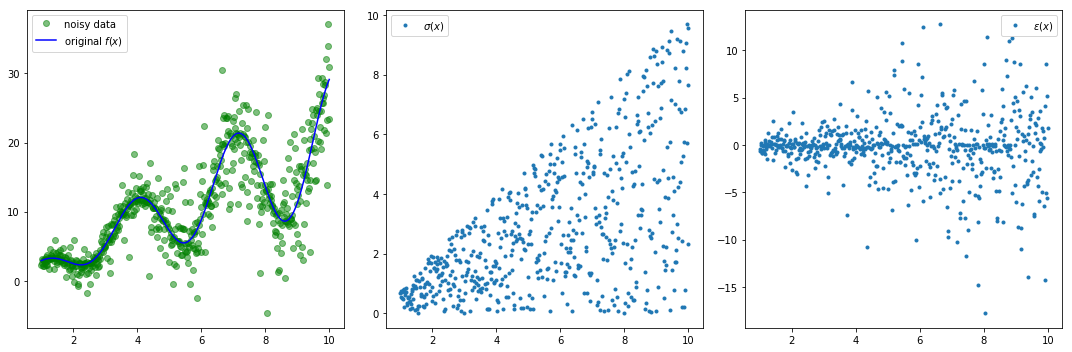

In [118]:
np.random.seed(123)
n = 600
c = 1
x = np.linspace(1, 10, n).reshape(n,1)
s, eps = np.array([]), np.array([])
for k in range(n):
    s = np.append(s, np.random.uniform(0,x[k],(1,)))
    eps = np.append(eps, np.random.normal(loc=0, scale=c*s[k], size=(1,)))
s = s.reshape([n,1])
eps = eps.reshape([n,1])
y_ = 2*x + x*np.sin(2*x)
y = y_ + eps
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(x,y,'go', alpha=0.5, label='noisy data');
plt.plot(x,y_,'b-',label='original $f(x)$');
plt.legend()
plt.subplot(1,3,2)
plt.plot(x,s,'.',label='$\sigma(x)$')
plt.legend()
plt.subplot(1,3,3)
plt.plot(x,eps,'.',label='$\epsilon(x)$')
plt.legend()
plt.tight_layout();

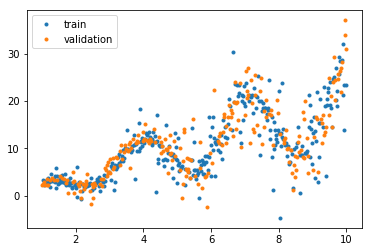

In [119]:
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)
n, m = x.shape
randvec = torch.randperm(n)
tr_inds, _ = torch.sort(randvec[:(n*3)//5])
val_inds, _ = torch.sort(randvec[(n*3)//5:])
x_train, x_val = x[tr_inds], x[val_inds]
y_train, y_val = y[tr_inds], y[val_inds]
xx_train, yy_train = x_train.data.numpy(), y_train.data.numpy()
xx_val, yy_val = x_val.data.numpy(), y_val.data.numpy()
plt.plot(xx_train, yy_train, '.', label='train')
plt.plot(xx_val, yy_val, '.', label='validation')
plt.legend();

## The objective is to learn the mean $\mu$ and std $\sigma$ as functions of the input $x$
## Define a simple neural network model that outputs $\mu_{\theta}(x)$ and $\sigma_{\theta}(x)$
## Also, define a loss function as the Gaussian negative log-likelihood
## $\ \ \ -\log(p_{\theta}(y|x)) = \frac{log(\sigma_{\theta}(x)^2)}{2} + \frac{(y-\mu_{\theta}(x))^2}{2\sigma_{\theta}(x)^{2}} + const.$

In [120]:
loss_fn = lambda mu, sigma, yi: torch.sum(torch.log(sigma**2) + ((yi - mu)**2)/(sigma**2))

## Model

In [132]:
D_in, H1, H2, D_out = 1, 30, 10, 2

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out),
    torch.nn.Softplus()
)

## Training

iteration #0: loss = 481.60535
iteration #5000: loss = 3.56471
iteration #10000: loss = 3.52009
iteration #15000: loss = 3.35613
iteration #20000: loss = 3.19536
iteration #25000: loss = 3.21238
iteration #30000: loss = 3.23719
iteration #35000: loss = 3.27886
iteration #40000: loss = 3.38765
iteration #45000: loss = 3.48803
iteration #50000: loss = 3.54285
iteration #55000: loss = 3.56424
iteration #60000: loss = 3.59730
iteration #65000: loss = 3.62986
iteration #70000: loss = 3.63497
iteration #75000: loss = 3.66175
iteration #80000: loss = 3.73391
iteration #85000: loss = 3.71044
iteration #90000: loss = 3.76932
iteration #95000: loss = 3.82503


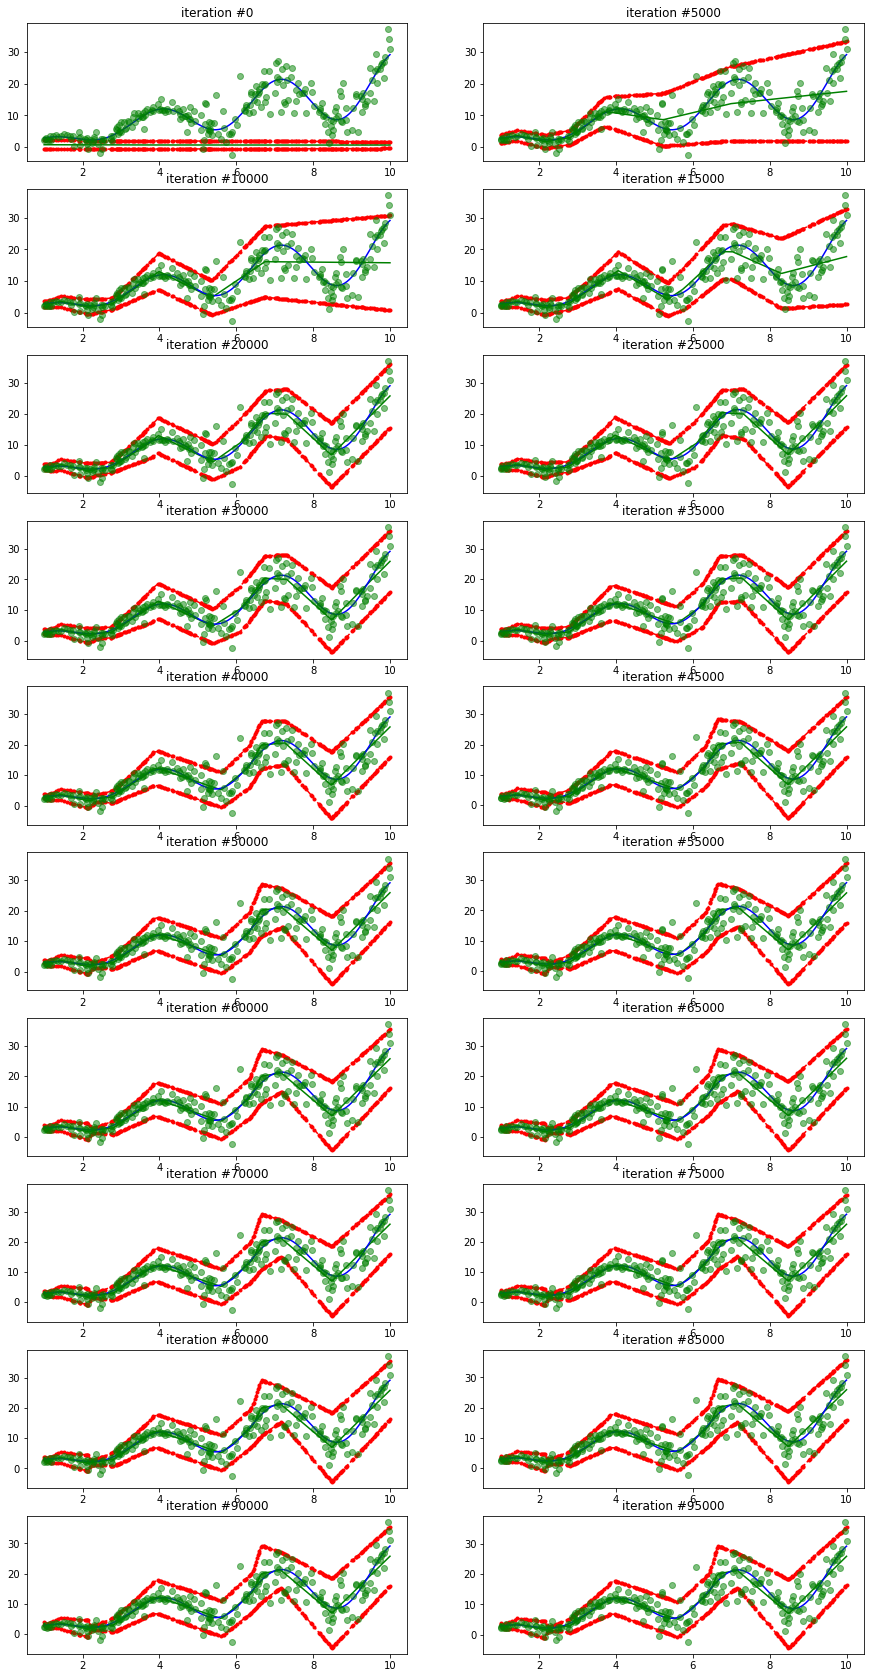

In [133]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
rng = int(1e5)
plt.figure(figsize=(15,(3*rng)//10000))
loss_val = 0.
for t in range(rng):
    model.zero_grad()
    y_pred = model(x_train)
    mu, sigma = y_pred[:,0], y_pred[:,1]
    loss = loss_fn(mu, sigma, y_train.flatten())/y_train.size(0)
    
    model.eval()
    with torch.no_grad():
        y_pred_val = model(x_val)
        mu_val, sigma_val = y_pred_val[:,0], y_pred_val[:,1]
        loss_val = loss_fn(mu_val, sigma_val, y_val.flatten())/y_val.size(0)

    if(t%5000==0):
        mu_val, sigma_val = y_pred_val[:,0].data.numpy(), y_pred_val[:,1].data.numpy()
        plt.subplot(rng//10000,2,t//5000+1)
        plt.plot(xx_val,mu_val+2*sigma_val,'.r--');
        plt.plot(xx_val,mu_val-2*sigma_val,'.r--');
        plt.plot(xx_val,mu_val,'g')
        plt.plot(x.data.numpy(),y_,'b')
        plt.plot(xx_val,yy_val,'go', alpha=0.5);
        plt.title("iteration #%d"%t)
        print("iteration #%d: loss = %-.5f"%(t, loss_val.item()))

    loss.backward()
    optimizer.step()

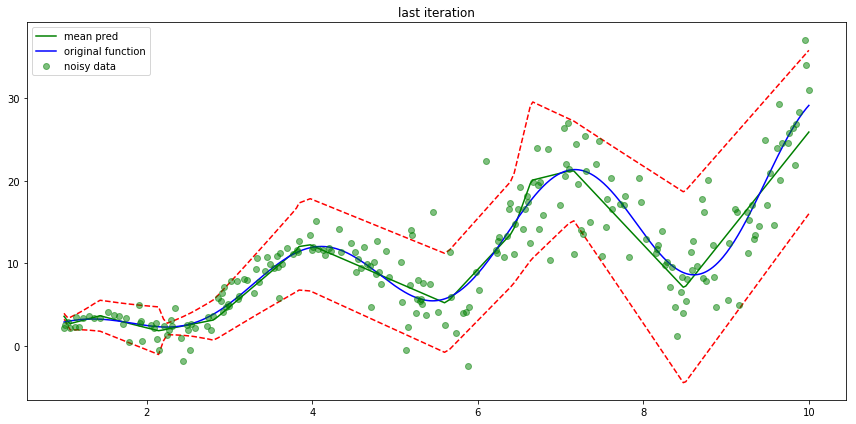

In [134]:
plt.figure(figsize=(12,6))
model.eval()
with torch.no_grad():
    y_pred_val = model(x_val)
mu_val, sigma_val = y_pred_val[:,0].data.numpy(), y_pred_val[:,1].data.numpy()
plt.plot(xx_val,mu_val+2*sigma_val,'r--')
plt.plot(xx_val,mu_val-2*sigma_val,'r--')
plt.plot(xx_val,mu_val,'g',label='mean pred')
plt.plot(x.data.numpy(),y_,'b', label='original function')
plt.plot(xx_val,yy_val,'go', alpha=0.5, label='noisy data')
plt.title("last iteration")
plt.legend()
plt.tight_layout();

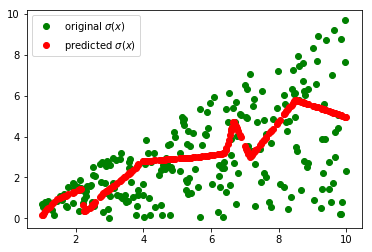

In [136]:
plt.plot(xx_val, s[val_inds], 'go', label='original $\sigma(x)$');
plt.plot(xx_val, sigma_val, 'ro', label='predicted $\sigma(x)$');
plt.legend();